# CS294-158 CW1 

In [1]:
import matplotlib.pyplot as plt
from tqdm import tnrange
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.optim
import torch.nn.functional as F
import torch.nn.init as init
import numpy as np
from models import WarmUpModel
from torchlib.dataset.utils import create_data_loader
import torchvision
from torchvision import transforms

Enable cuda False


In [3]:
def sample_data():
    count = 10000
    rand = np.random.RandomState(0)
    a = 0.3 + 0.1 * rand.randn(count)
    b = 0.8 + 0.05 * rand.randn(count)
    mask = rand.rand(count) < 0.5
    samples = np.clip(a * mask + b * (1 - mask), 0.0, 1.0)
    return np.digitize(samples, np.linspace(0.0, 1.0, 100))

In [4]:
model = WarmUpModel()

In [5]:
x = sample_data().astype(np.int64)
x_train_val = x[:8000]
x_test = x[8000:]
x_train = x_train_val[:7000]
x_val = x_train_val[7000:]
print(x_train.shape, x_val.shape, x_test.shape)

(7000,) (1000,) (2000,)


In [6]:

optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)
n_epoch = 50
batch_size = 100
train_data_loader = create_data_loader((x_train,), batch_size=batch_size, drop_last=False)
train_loss = []
train_loss_x = []
val_loss = []
val_loss_x = []

In [7]:
train_log = []
val_log = []
min_nll_val = np.inf
best_theta = theta
for i in range(1000):
    prob = torch.softmax(theta, dim=0)[X_train.long()]
#     loss = torch.sum(-torch.log(prob))
    loss = torch.mean(-torch.log(prob))
    
    theta_optimizer.zero_grad()
    loss.backward()
    theta_optimizer.step()
    
    train_prob = torch.softmax(theta, dim=0)[X_train.long()]
    nll_train = get_NLL(train_prob)
    train_log.append(nll_train.item())
    
    val_prob = torch.softmax(theta, dim=0)[X_val.long()]
    nll_val = get_NLL(val_prob)
    val_log.append(nll_val.item())
    if (nll_val < min_nll_val):
        min_nll_val = nll_val
        best_theta = theta.clone()
    print("Epoch-{:d} loss: {:.4f}, train_bits: {:.3f}, val_bits: {:.3f}".format(i + 1, loss, nll_train, nll_val))

In [9]:
with torch.no_grad():
    x_test_tensor = torch.from_numpy(x_test)
    test_logits = model.forward(x_test_tensor)
    nll_test = F.cross_entropy(test_logits, x_test_tensor)
    print('Negative log likelihood of testing data is {:.4f}'.format(nll_test / np.log(2.)))

Negative log likelihood of testing data is 5.8583


# 2D data

In [12]:

distribution = np.load('data/distribution.npy')
print(np.sum(distribution), distribution.shape)

1.0 (200, 200)


In [13]:

samples = np.random.choice(np.arange(np.prod(distribution.shape)), size=100000, 
                           p=distribution.reshape(-1))
x1 = samples // 200
x2 = samples - 200 * x1
x = np.stack((x1, x2), axis=-1)
print(x.shape)
x_train = x[:70000]
x_val = x[70000:80000]
x_test = x[80000:]
train_data_loader = create_data_loader((x_train,), batch_size=100, drop_last=False, shuffle=True)

(100000, 2)


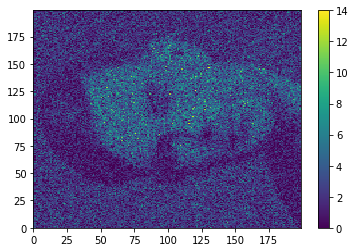

In [14]:
hist_samples = plt.hist2d(x1, x2, bins=200)
plt.colorbar(hist_samples[3])

# Autoregressive

In [15]:
from models import TwoDimensionModel

In [16]:
model = TwoDimensionModel()

In [17]:

optimizer = torch.optim.SGD(model.parameters(), lr=5e-2)
n_epoch = 20
batch_size = 100
train_loss = []
train_loss_x = []
val_loss = []
val_loss_x = []

In [18]:
step = 0
for epoch in tnrange(n_epoch):
    for data in train_data_loader:
        data = data[0]
        x1 = data[:, 0]
        x2 = data[:, 1]
        optimizer.zero_grad()
        x1_logits, x2_logits = model.forward(data)
        loss = F.cross_entropy(x1_logits, x1) + F.cross_entropy(x2_logits, x2)
        train_loss.append(loss.item() / np.log(2.) / 2.)
        train_loss_x.append(step)
        loss.backward()
        optimizer.step()
        step += 1
        
    with torch.no_grad():
        model.eval()
        x_val_tensor = torch.from_numpy(x_val)
        x1 = x_val_tensor[:, 0]
        x2 = x_val_tensor[:, 1]
        x1_logits, x2_logits = model.forward(x_val_tensor)
        loss = F.cross_entropy(x1_logits, x1) + F.cross_entropy(x2_logits, x2)
        val_loss.append(loss / np.log(2.) / 2.)
        val_loss_x.append(step)
        model.train()

In [20]:
with torch.no_grad():
    model.eval()
    x_test_tensor = torch.from_numpy(x_test)
    x1 = x_test_tensor[:, 0]
    x2 = x_test_tensor[:, 1]
    x1_logits, x2_logits = model.forward(x_test_tensor)
    loss = F.cross_entropy(x1_logits, x1) + F.cross_entropy(x2_logits, x2)
    print('Negative log likelihood of testing data is {:.4f}'.format(loss / np.log(2.) / 2.))
    model.train()

Negative log likelihood of testing data is 7.6134


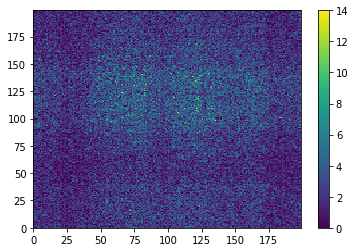

In [21]:
x1, x2 = model.sample(100000)
hist_samples = plt.hist2d(x1, x2, bins=200)
plt.colorbar(hist_samples[3])

In [22]:
from models import TwoDimensionMADE

In [23]:
model = TwoDimensionMADE()

In [24]:

optimizer = torch.optim.SGD(model.parameters(), lr=5e-2)
n_epoch = 20
batch_size = 100
train_loss = []
train_loss_x = []
val_loss = []
val_loss_x = []

In [25]:
step = 0
for epoch in tnrange(n_epoch):
    for data in train_data_loader:
        data = data[0]
        x1 = data[:, 0]
        x2 = data[:, 1]
        optimizer.zero_grad()
        x1_logits, x2_logits = model.forward(data)
        loss = F.cross_entropy(x1_logits, x1) + F.cross_entropy(x2_logits, x2)
        train_loss.append(loss.item() / np.log(2.) / 2.)
        train_loss_x.append(step)
        loss.backward()
        optimizer.step()
        step += 1
        
    # evaluate validation loss
    with torch.no_grad():
        model.eval()
        x_val_tensor = torch.from_numpy(x_val)
        x1 = x_val_tensor[:, 0]
        x2 = x_val_tensor[:, 1]
        x1_logits, x2_logits = model.forward(x_val_tensor)
        loss = F.cross_entropy(x1_logits, x1) + F.cross_entropy(x2_logits, x2)
        val_loss.append(loss / np.log(2.) / 2.)
        val_loss_x.append(step)
        model.train()

In [27]:
with torch.no_grad():
    model.eval()
    x_test_tensor = torch.from_numpy(x_test)
    x1 = x_test_tensor[:, 0]
    x2 = x_test_tensor[:, 1]
    x1_logits, x2_logits = model.forward(x_test_tensor)
    loss = F.cross_entropy(x1_logits, x1) + F.cross_entropy(x2_logits, x2)
    print('Negative log likelihood of testing data is {:.4f}'.format(loss / np.log(2.) / 2.))
    model.train()

Negative log likelihood of testing data is 7.6111


In [2]:
x1, x2 = model.sample(100000)
hist_samples = plt.hist2d(x1, x2, bins=200)
plt.colorbar(hist_samples[3])

NameError: name 'sample2d' is not defined

# pixel CNN

In [ ]:
class MaskedConv2d(nn.Conv2d):

    def __init__(self, in_channels, out_channels, kernel_size, mode, prev_m, img_channels=3, stride=1, bias=True, m=None):
#         super(MaskedConv2d, self).__init__(in_channels, out_channels, kernel_size, stride,
#                  padding=0, dilation=0, groups=1, bias=bias, padding_mode='zeros')
        super(MaskedConv2d, self).__init__(in_channels, out_channels, kernel_size, stride,
             padding=0, dilation=0, groups=1, bias=bias)
        if m is None:
            self.register_buffer("m", torch.from_numpy(np.random.randint(0, img_channels, [out_channels])).float())
        else:
            self.register_buffer("m", m)
            
        self.register_buffer("mask", torch.ones_like(self.weight))
        self.set_mask(mode, prev_m)
        
    def forward(self, x):
        p2d = (self.kernel_size[0] // 2, self.kernel_size[0] // 2, self.kernel_size[1] // 2, self.kernel_size[1] // 2)
        return F.conv2d(F.pad(x, p2d), self.mask * self.weight, self.bias, self.stride)

    def set_mask(self, mode, prev_m):
        """ Generate mask according to the mask indicator vector of the input and current layer.
        Args
            mode: 'a' or 'b'
            prev_m: mask vector of the input.
        """
        if mode != 'a' and mode != 'b':
            raise ValueError("Mask mode should be 'a' or 'b'.")
            
        center_h, center_w = self.kernel_size[0] // 2, self.kernel_size[1] // 2
        
        self.mask.data = torch.ones_like(self.weight, dtype=torch.float32)
        self.mask[:, :, center_h, center_w:] = 0.0
        if center_h + 1 < self.kernel_size[0]:
            self.mask[:, :, center_h + 1:, :] = 0.0
        
        if mode == 'a':
            self.mask[:, :, center_h, center_w] = self.m.view(-1, 1) > prev_m.view(1, -1)
        elif mode == 'b':
            self.mask[:, :, center_h, center_w] = self.m.view(-1, 1) >= prev_m.view(1, -1)

In [ ]:
class ResidualBlock(nn.Module):
    
    def __init__(self, in_channels, prev_m, mode='b', img_channels=3):
        super(ResidualBlock, self).__init__()
        self.h = in_channels // 2
        self.in_channels = in_channels
        
        self.mask_conv1 = MaskedConv2d(in_channels, self.h, [1, 1], mode, prev_m, img_channels)
        self.bn_1 = nn.BatchNorm2d(self.h)
        self.mask_conv2 = MaskedConv2d(self.h, self.h, [3, 3], mode, self.mask_conv1.m, img_channels)
        self.bn_2 = nn.BatchNorm2d(self.h)

        self.mask_conv3 = MaskedConv2d(self.h, in_channels, [1, 1], mode, self.mask_conv2.m, img_channels, m=prev_m)
        self.last_m = self.mask_conv3.m 
        self.bn_3 = nn.BatchNorm2d(in_channels)
        
    def forward(self, x):
        out = self.bn_1(self.mask_conv1(F.relu(x)))
        out = self.bn_2(self.mask_conv2(F.relu(out)))
        out = self.bn_3(self.mask_conv3(F.relu(out))) + x
        return out

In [ ]:
class PixelCNN(nn.Module):
    
    def __init__(self, h, n_channels=3, n_classes=256):
        super(PixelCNN, self).__init__()
        self.h = h
        self.n_channels = n_channels
        self.n_classes = n_classes
        
        self.init_m = torch.from_numpy(np.array(list(np.arange(n_channels)))).float()
        self.mask_conv1 = MaskedConv2d(n_channels, 2 * h, [7, 7], 'a', self.init_m, n_channels)
        
        self.residuals = nn.ModuleList()
        prev_m = self.mask_conv1.m 
        for i in range(12):
            self.residuals.append(ResidualBlock(2 * h, prev_m, 'b', n_channels))
            prev_m = self.residuals[-1].last_m
        self.mask_conv2 = MaskedConv2d(2 * h, 2 * h, [1, 1], 'b', self.residuals[-1].last_m, n_channels)

        out_m = []
        for i in range(n_channels):
            out_m.extend([i] * n_classes)
        self.mask_conv3 = MaskedConv2d(2 * h, n_classes * n_channels, [1, 1], 'b', self.mask_conv2.m, n_channels,
                                       m=torch.from_numpy(np.array(out_m)).float())
        
    def forward(self, x):
        out = self.mask_conv1(x)
        for res in self.residuals:
            out = res(out)
        out = self.mask_conv2(F.relu(out))
        out = self.mask_conv3(F.relu(out))

        logits = out.view([x.shape[0], x.shape[1], self.n_classes, x.shape[2], x.shape[3]]).permute([0, 2, 1, 3, 4])
        out = F.softmax(logits, dim=1)
        return logits, out

    
    def sample_once(self):
        x = torch.zeros([1, self.n_channels, 28, 28]).float()
        if next(self.parameters()).is_cuda:
            x = x.cuda()
        for i in range(28):
            for j in range(28):
                for k in range(self.n_channels):
                    _, distrib = self.forward(x)
#                     print(distrib[0, k, :, i, j].cpu().data.numpy())
                    x[0, k, i, j] = np.random.choice(self.n_classes, p=distrib[0, :, k, i, j].cpu().data.numpy())
        return x.detach()